# 多层感知机的从零实现

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from d2l import torch as d2l

## 准备数据集

In [2]:
dataset = d2l.FashionMNIST(batch_size=64)
dataset.val.data = dataset.val.data / 255
dataset.train.data  = dataset.train.data / 255

In [3]:
train_iter = dataset.get_dataloader(train=True)
test_iter = dataset.get_dataloader(train=False)

In [4]:
train_iter

In [5]:
for X, y in train_iter:
    print(X.shape, y.shape)
    print(np.unique(y))
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
[0 1 2 3 4 5 6 7 8 9]


## 定义损失函数

In [6]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

## 定义网络结构

### 线性层

In [7]:
class Linear:
    def __init__(self, input_size, output_size):
        self.W = torch.normal(0, 0.01, size=(input_size, output_size), requires_grad=True)
        self.b = torch.zeros(output_size, requires_grad=True)
        self.params = [self.W, self.b]

    def __call__(self, H):
        return H @ self.W + self.b

### 激活层

In [8]:
def sigmoid(H):
    return 1 / (1 + torch.exp(H))
def ReLu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### 定义SoftMax层

In [9]:
def SoftMax(H: torch.Tensor):
    expH = torch.exp(H)
    return expH / expH.sum(1, keepdim=True)

### dropout 层

In [10]:
class DropOut:
    def __init__(self, dropout) -> None:
        assert 0 <= dropout <= 1
        self.dropout = dropout

    def __call__(self, X):
        if self.dropout == 1:
            return torch.zeros_like(X)
        if self.dropout == 0:
            return X
        mask = (torch.randn(X.shape) > self.dropout).float()

        return mask * X / (1.0 - self.dropout)


In [11]:
drop = DropOut(0.1)
drop.__class__ == DropOut

True

### 定义神经网络

In [12]:
class MLP:
    def __init__(self):
        self.Sequential = [
            ('00-Flatten', lambda X: X.reshape(-1, 28*28)),
            ('01-linear', Linear(28*28, 256)),
            ('DropOut', DropOut(0.2)), 
            ('02-ReLu', ReLu),
            ('03-linear', Linear(256, 256)),
            ('DropOut', DropOut(0.2)),
            ('04-ReLU', ReLu),
            ('05-linear', Linear(256, 10)),
            ('06-ReLU', ReLu),
            ('08-SoftMax', SoftMax)
        ]

    def show(self, X):
        for layner_name, layer in self.Sequential:
            print(f"{layner_name:30}{X.shape}", end=' -> ')
            X = layer(X)
            print(X.shape)
        return X

    def get_params(self):
        """获取神经网络中全部参数"""
        params = []
        for _, layer in self.Sequential:
            if 'params' in layer.__dict__:
                params.extend(layer.params)
        return params

    def __call__(self, X, is_training=True):
        for _, layer in self.Sequential:
            if layer.__class__ == DropOut and not is_training:
                continue
            X = layer(X)
            
        return X

### 测试

In [13]:
linear = Linear(10, 2)
H = torch.arange(100, dtype=torch.float32).reshape(-1, 10)
linear(H)

tensor([[ 0.1595, -0.2181],
        [ 0.6790, -0.6686],
        [ 1.1984, -1.1192],
        [ 1.7178, -1.5697],
        [ 2.2372, -2.0203],
        [ 2.7566, -2.4708],
        [ 3.2760, -2.9214],
        [ 3.7954, -3.3719],
        [ 4.3149, -3.8225],
        [ 4.8343, -4.2730]], grad_fn=<AddBackward0>)

In [14]:
net = MLP()
params = net.get_params()

In [15]:
X, y = next(iter(train_iter))
X.shape

torch.Size([64, 1, 28, 28])

In [16]:
y_hat = net.show(X)

00-Flatten                    torch.Size([64, 1, 28, 28]) -> torch.Size([64, 784])
01-linear                     torch.Size([64, 784]) -> torch.Size([64, 256])
DropOut                       torch.Size([64, 256]) -> torch.Size([64, 256])
02-ReLu                       torch.Size([64, 256]) -> torch.Size([64, 256])
03-linear                     torch.Size([64, 256]) -> torch.Size([64, 256])
DropOut                       torch.Size([64, 256]) -> torch.Size([64, 256])
04-ReLU                       torch.Size([64, 256]) -> torch.Size([64, 256])
05-linear                     torch.Size([64, 256]) -> torch.Size([64, 10])
06-ReLU                       torch.Size([64, 10]) -> torch.Size([64, 10])
08-SoftMax                    torch.Size([64, 10]) -> torch.Size([64, 10])


In [17]:
for param in params:
    print(param.shape)

torch.Size([784, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 10])
torch.Size([10])


In [18]:
l = cross_entropy(y_hat, y).mean()

In [19]:
params[-1].grad

In [20]:
l.backward()
params[-1].grad

tensor([ 0.0188, -0.0078,  0.0172, -0.0375, -0.0031,  0.0203, -0.0125, -0.0266,
        -0.0281, -0.0547])

##  模型构建

In [21]:
from typing import Literal, Type
from IPython import display
from matplotlib_inline import backend_inline


import torch.utils
import torch.utils.data

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """累加"""
    def __init__(self, n) -> None:
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class ModelTrain:

    def  __init__(self,
            net,
            params,
            solver: Literal['sgd'] = 'sgd', 
            alpha = 0.01, 
            max_iter = 100,
            loss:  Literal['cross_entropy', 'squared', 'absolute', 'L1', 'L2'] = 'cross_entropy',
            lambd: float = 0.0,
            *args, 
            **kwargs):
        self.net = net  # 神经网络
        self.params = params  # 模型参数
        self.alpha = alpha  # 学习率
        self.max_iter = max_iter    # 最大迭代次数
        self.loss = self._get_loss(loss)     # 损失函数
        self.solver = self._get_solver(solver, lambd)     # 优化器

    def fit(self, train_iter, test_iter):
        """拟合"""
        animator = d2l.Animator(xlabel='epoch', xlim=[1, self.max_iter], ylim=[0., 1.0],
                        legend=['train loss', 'train acc', 'test acc'], figsize=(6, 4))
        for epoch in range(self.max_iter):
            train_metric = Accumulator(3)   # 训练数据的累加器
            test_metric = Accumulator(2)    # 测试数据的累加器
            for X, y in train_iter:
                y_hat = self.net(X) # 前向传播
                l = self.loss(y_hat, y).sum() # 计算损失
                l.backward()
                self.solver(self.params, alpha=self.alpha, batch_size=y.shape[0])   # 反向传播更新梯度
                train_metric.add(l, accuracy(self.net(X, is_training=False), y), y.numel())
            for X, y in test_iter:
                test_metric.add(accuracy(self.net(X, is_training=False), y), y.numel())
            train_loss = train_metric[0] / train_metric[-1]
            train_acc = train_metric[1] / train_metric[-1]
            test_acc = test_metric[0] / test_metric[-1]
            
            animator.add(epoch, (train_loss, train_acc, test_acc))
        print(f'train acc: {train_acc:.2f}, test acc: {test_acc:.2f}')

    def _get_solver(self, slover, lambd):
        """优化器"""
        if slover == 'sgd':
            def sgd(params, alpha, batch_size):
                with torch.no_grad():
                    for param in params:
                        param[:] = param * (1 - lambd * alpha) - alpha * param.grad / batch_size
                        param.grad.zero_()
            return sgd
        raise ValueError
    
    def _get_loss(self, loss):
        # 交叉熵损失
        if loss == 'cross_entropy':
            return lambda y_hat, y : -torch.log(y_hat[range(len(y_hat)), y])
        # 均方损失 
        if loss == 'squared' or loss == 'L2':
            return lambda y_hat, y : 1/2 * (y_hat - y)**2
        # 绝对损失
        if loss ==  'absolute' or loss == 'L1':
            return lambda y_hat, y : (y_hat - y).abs()
        else:
            raise ValueError


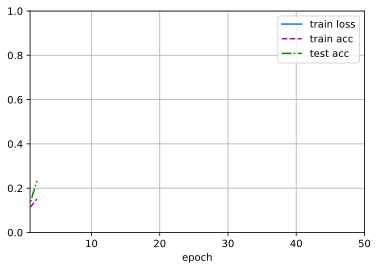

In [ ]:
net = MLP()
model = ModelTrain(net=net, params=net.get_params(), alpha=0.1, solver='sgd', max_iter=50, loss='cross_entropy', lambd=0.0)
model.fit(train_iter, test_iter)